# Multilevel regression in Turing

## Setup plotting

In [1]:
using PyCall
font_manager = pyimport("matplotlib.font_manager")
font_manager.fontManager.addfont("/usr/share/fonts/OTF/lmroman10-regular.otf")
PyDict(pyimport("matplotlib")["rcParams"])["font.serif"] = ["Latin Modern Roman"]
# font_manager.fontManager.addfont("/usr/share/fonts/OTF/lmsans10-regular.otf")
# PyDict(pyimport("matplotlib")["rcParams"])["font.serif"] = ["Latin Modern Sans"]

1-element Vector{String}:
 "Latin Modern Roman"

In [2]:
using Plots
font = Plots.font("Latin Modern Roman", 18)
# font = Plots.font("Latin Modern Sans", 18)
pyplot(titlefont=font, guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)

Plots.PyPlotBackend()

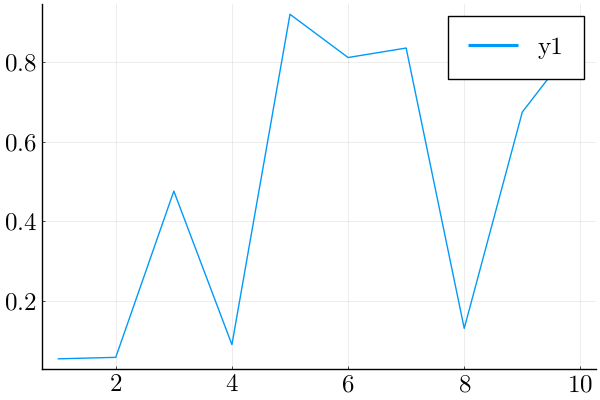

In [3]:
x = 1:10; y = rand(10); # These are the plotting data
plot(x, y)

## Import libraries

You may need to install `julia` package `ForwardDiff` if it isn't already installed.
```bash
julia -e 'using Pkg; Pkg.status()'
julia -e 'using Pkg; Pkg.instantiate(); Pkg.API.precompile()'
julia -e 'using Pkg; Pkg.add("ForwardDiff")'
```

In [4]:
# Import Turing and Distributions.
using Turing, Distributions

# Import RDatasets.
using RDatasets

# Import MCMCChains, Plots, and StatPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Functionality for splitting and normalizing the data.
using MLDataUtils: shuffleobs, splitobs, rescale!

# Functionality for evaluating the model predictions.
using Distances

# Functionality for reading CSV files into DataFrames
using CSV
using DataFrames

# Set a seed for reproducibility.
using Random
Random.seed!(0)

# Hide the progress prompt while sampling.
# Turing.turnprogress(false);

## Load data

In [27]:
data_srrs2 = CSV.File(download("http://www.stat.columbia.edu/~gelman/arm/examples/radon/srrs2.dat")) |> DataFrame;
data_cty = CSV.File(download("http://www.stat.columbia.edu/~gelman/arm/examples/radon/cty.dat")) |> DataFrame;

In [29]:
println(size(data_srrs2))
print(size(data_cty))

(12777, 25)
(3194, 7)

In [23]:
data_srrs2[ [1:6; 2073:2078; 4052:4057], : ]

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement
,Int64,String,String,Int64,String,Int64,Int64,Int64,Int64,String
1,1,AZ,AZ,4,85920,1,1,1,2,N
2,2,AZ,AZ,4,85920,1,0,9,0,
3,3,AZ,AZ,4,85924,1,1,1,3,N
4,4,AZ,AZ,4,85925,1,1,1,3,N
5,5,AZ,AZ,4,85932,1,1,1,1,N
6,6,AZ,AZ,4,85936,1,1,1,1,N
7,2073,IN,IN,18,46919,3,1,0,4,Y
8,2074,IN,IN,18,46928,3,1,1,2,N
9,2075,IN,IN,18,46933,3,1,1,1,N


In [26]:
data_cty[[1:5; 200:204; 2075:2079], :]

,stfips,ctfips,st,cty,lon,lat,Uppm
,Int64,Int64,String,String,Float64,Float64,Float64
1,1,1,AL,AUTAUGA,-86.643,32.534,1.78331
2,1,3,AL,BALDWIN,-87.75,30.661,1.38323
3,1,5,AL,BARBOUR,-85.393,31.87,2.10105
4,1,7,AL,BIBB,-87.126,32.998,1.67313
5,1,9,AL,BLOUNT,-86.568,33.981,1.88501
6,6,79,CA,SANLUISOBISPO,-120.451,35.388,2.48984
7,6,81,CA,SANMATEO,-122.355,37.438,1.11912
8,6,81,CA,SANMATEO,-122.147,37.275,1.11912
9,6,83,CA,SANTABARBARA,-119.968,34.011,2.56646


In [49]:
cty_mn = data_cty[∈(["MN"]).(data_cty.st),:];

In [52]:
cty_mn[[1:4; 77:80],:]

,stfips,ctfips,st,cty,lon,lat,Uppm
,Int64,Int64,String,String,Float64,Float64,Float64
1,27,1,MN,AITKIN,-93.415,46.608,0.502054
2,27,3,MN,ANOKA,-93.246,45.273,0.428565
3,27,5,MN,BECKER,-95.674,46.935,0.892741
4,27,7,MN,BELTRAMI,-94.937,47.974,0.552472
5,27,149,MN,STEVENS,-96.0,45.586,1.60124
6,27,151,MN,SWIFT,-95.681,45.283,1.37167
7,27,153,MN,TODD,-94.897,46.071,0.95424
8,27,155,MN,TRAVERSE,-96.471,45.772,1.64476


## Preprocess data

### Manipulate data structure into appropriate input form

Extract a training and testing set from the data

In [10]:
# Remove the model column.
select!(data, Not(:Model))

# Split our dataset 70%/30% into training/test sets.
trainset, testset = splitobs(shuffleobs(data), 0.7)

(22×11 SubDataFrame
 Row │ MPG      Cyl    Disp     HP     DRat     WT       QSec     VS     AM    ⋯
     │ Float64  Int64  Float64  Int64  Float64  Float64  Float64  Int64  Int64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    27.3      4     79.0     66     4.08    1.935    18.9       1      1 ⋯
   2 │    21.4      6    258.0    110     3.08    3.215    19.44      1      0
   3 │    30.4      4     95.1    113     3.77    1.513    16.9       1      1
   4 │    24.4      4    146.7     62     3.69    3.19     20.0       1      0
   5 │    33.9      4     71.1     65     4.22    1.835    19.9       1      1 ⋯
   6 │    10.4      8    460.0    215     3.0     5.424    17.82      0      0
   7 │    15.5      8    318.0    150     2.76    3.52     16.87      0      0
   8 │    14.7      8    440.0    230     3.23    5.345    17.42      0      0
   9 │    22.8      4    140.8     95     3.92    3.15     22.9       1      0 ⋯
  10 │    21.0      

Specify the outcome variable for predicton.

In [11]:
target = :MPG

10×10 Matrix{Float64}:
 6.0  167.6  123.0  3.92  3.44   18.3   1.0  0.0  4.0  4.0
 8.0  301.0  335.0  3.54  3.57   14.6   0.0  1.0  5.0  8.0
 8.0  275.8  180.0  3.07  4.07   17.4   0.0  0.0  3.0  3.0
 8.0  360.0  245.0  3.21  3.57   15.84  0.0  0.0  3.0  4.0
 4.0  121.0  109.0  4.11  2.78   18.6   1.0  1.0  4.0  2.0
 6.0  225.0  105.0  2.76  3.46   20.22  1.0  0.0  3.0  1.0
 6.0  145.0  175.0  3.62  2.77   15.5   0.0  1.0  5.0  6.0
 8.0  304.0  150.0  3.15  3.435  17.3   0.0  0.0  3.0  2.0
 4.0  120.3   91.0  4.43  2.14   16.7   0.0  1.0  5.0  2.0
 8.0  275.8  180.0  3.07  3.73   17.6   0.0  0.0  3.0  3.0

Convert data to matrix form.

In [14]:
train = Matrix(select(trainset, Not(target)))

22×10 Matrix{Float64}:
 4.0   79.0   66.0  4.08  1.935  18.9   1.0  1.0  4.0  1.0
 6.0  258.0  110.0  3.08  3.215  19.44  1.0  0.0  3.0  1.0
 4.0   95.1  113.0  3.77  1.513  16.9   1.0  1.0  5.0  2.0
 4.0  146.7   62.0  3.69  3.19   20.0   1.0  0.0  4.0  2.0
 4.0   71.1   65.0  4.22  1.835  19.9   1.0  1.0  4.0  1.0
 8.0  460.0  215.0  3.0   5.424  17.82  0.0  0.0  3.0  4.0
 8.0  318.0  150.0  2.76  3.52   16.87  0.0  0.0  3.0  2.0
 8.0  440.0  230.0  3.23  5.345  17.42  0.0  0.0  3.0  4.0
 4.0  140.8   95.0  3.92  3.15   22.9   1.0  0.0  4.0  2.0
 6.0  160.0  110.0  3.9   2.62   16.46  0.0  1.0  4.0  4.0
 8.0  275.8  180.0  3.07  3.78   18.0   0.0  0.0  3.0  3.0
 8.0  350.0  245.0  3.73  3.84   15.41  0.0  0.0  3.0  4.0
 8.0  351.0  264.0  4.22  3.17   14.5   0.0  1.0  5.0  4.0
 4.0  108.0   93.0  3.85  2.32   18.61  1.0  1.0  4.0  1.0
 6.0  160.0  110.0  3.9   2.875  17.02  0.0  1.0  4.0  4.0
 6.0  167.6  123.0  3.92  3.44   18.9   1.0  0.0  4.0  4.0
 8.0  400.0  175.0  3.08  3.845  

In [15]:
test = Matrix(select(testset, Not(target)))

10×10 Matrix{Float64}:
 6.0  167.6  123.0  3.92  3.44   18.3   1.0  0.0  4.0  4.0
 8.0  301.0  335.0  3.54  3.57   14.6   0.0  1.0  5.0  8.0
 8.0  275.8  180.0  3.07  4.07   17.4   0.0  0.0  3.0  3.0
 8.0  360.0  245.0  3.21  3.57   15.84  0.0  0.0  3.0  4.0
 4.0  121.0  109.0  4.11  2.78   18.6   1.0  1.0  4.0  2.0
 6.0  225.0  105.0  2.76  3.46   20.22  1.0  0.0  3.0  1.0
 6.0  145.0  175.0  3.62  2.77   15.5   0.0  1.0  5.0  6.0
 8.0  304.0  150.0  3.15  3.435  17.3   0.0  0.0  3.0  2.0
 4.0  120.3   91.0  4.43  2.14   16.7   0.0  1.0  5.0  2.0
 8.0  275.8  180.0  3.07  3.73   17.6   0.0  0.0  3.0  3.0

In [13]:
train_target = trainset[:, target];
test_target = testset[:, target];

### Transform data

Standardize the data features.

In [16]:
μ, σ = rescale!(train; obsdim = 1)

([6.0, 231.25454545454548, 136.4090909090909, 3.6459090909090914, 3.181227272727273, 18.14090909090909, 0.5, 0.4090909090909091, 3.6363636363636362, 2.5], [1.8516401995451028, 139.64166975060107, 64.88939974398129, 0.5406755834879975, 1.1276522569276897, 1.8090958254409035, 0.511766315719159, 0.5032362797401964, 0.657951694959769, 1.2630273533214136])

In [17]:
train

22×10 Matrix{Float64}:
 -1.08012  -1.09032   -1.08506   …   1.17422   0.552679  -1.18762
  0.0       0.191529  -0.406986     -0.81292  -0.967189  -1.18762
 -1.08012  -0.975028  -0.360754      1.17422   2.07255   -0.395874
 -1.08012  -0.605511  -1.14671      -0.81292   0.552679  -0.395874
 -1.08012  -1.1469    -1.10047       1.17422   0.552679  -1.18762
  1.08012   1.63809    1.21115   …  -0.81292  -0.967189   1.18762
  1.08012   0.6212     0.209447     -0.81292  -0.967189  -0.395874
  1.08012   1.49487    1.44231      -0.81292  -0.967189   1.18762
 -1.08012  -0.647762  -0.638149     -0.81292   0.552679  -0.395874
  0.0      -0.510267  -0.406986      1.17422   0.552679   1.18762
  1.08012   0.318998   0.671772  …  -0.81292  -0.967189   0.395874
  1.08012   0.850358   1.67348      -0.81292  -0.967189   1.18762
  1.08012   0.857519   1.96628       1.17422   2.07255    1.18762
 -1.08012  -0.882649  -0.66897       1.17422   0.552679  -1.18762
  0.0      -0.510267  -0.406986      1.17422   0

In [18]:
rescale!(test, μ, σ; obsdim = 1)

([6.0, 231.25454545454548, 136.4090909090909, 3.6459090909090914, 3.181227272727273, 18.14090909090909, 0.5, 0.4090909090909091, 3.6363636363636362, 2.5], [1.8516401995451028, 139.64166975060107, 64.88939974398129, 0.5406755834879975, 1.1276522569276897, 1.8090958254409035, 0.511766315719159, 0.5032362797401964, 0.657951694959769, 1.2630273533214136])

In [19]:
test

10×10 Matrix{Float64}:
  0.0      -0.455842  -0.206645  …  -0.81292   0.552679   1.18762
  1.08012   0.49946    3.06045       1.17422   2.07255    4.35462
  1.08012   0.318998   0.671772     -0.81292  -0.967189   0.395874
  1.08012   0.92197    1.67348      -0.81292  -0.967189   1.18762
 -1.08012  -0.789553  -0.422397      1.17422   0.552679  -0.395874
  0.0      -0.04479   -0.48404   …  -0.81292  -0.967189  -1.18762
  0.0      -0.617685   0.594718      1.17422   2.07255    2.77112
  1.08012   0.520944   0.209447     -0.81292  -0.967189  -0.395874
 -1.08012  -0.794566  -0.699792      1.17422   2.07255   -0.395874
  1.08012   0.318998   0.671772     -0.81292  -0.967189   0.395874

Standardize outcome data as well.

In [20]:
μtarget, σtarget = rescale!(train_target; obsdim = 1);
rescale!(test_target, μtarget, σtarget; obsdim = 1);

## Define model

One linear model to predict the outcome variable `MPG` from the other variables in the data set is a so-called fixed effects model given by

$$
\mathrm{MPG}_i \sim \mathcal{N}(\alpha + \beta^T \mathbf{X}_i, \sigma^2)
$$

Note here that the slope parameters $\beta^T$ and the intercept $\alpha$ are fixed across all data.